In [58]:
import math
import random
# carry over from previous chapters

def normal_cdf(x, mu=0, sigma=1):
    return (1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2

# Find the value corresponding to the specified probability
def inverse_normal_cdf(p, mu=0, sigma=1, tolerance=0.00001):
    """find approximate inverse using binary search"""
    
    # if not standard , compute standard and rescale
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)
    
    low_z, low_p = -10.0, 0          # normal_cdf(-10) is (very close to) 0
    hi_z, hi_p = 10.0, 1             # normal_cdf(10)  is (very close to) 1
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2   # consider the midpoint
        mid_p = normal_cdf(mid_z)    # and the cdf's value there
        if mid_p < p:
            # midpoint is still too low, search above it
            low_z, low_p = mid_z, mid_p
        elif mid_p > p:
            # midpoint is still too high, search below it
            hi_z, hi_p = mid_z, mid_p
        else:
            break
            
    return mid_z

In [59]:
def normal_approximation_to_binomial(n, p):
    """finds mu and sigma correspoinding to a Binomial(n, p)"""
    mu = p * n
    sigma = math.sqrt(p * (1-p) * n)
    return mu, sigma

# the normal cdf _is_ the probability the variable is below a threshold normal_probability_below = normal_cdf
def normal_probability_above(lo, mu=0, sigma=1):
    return 1 - normal_cdf(lo, mu, sigma)

# it's between if it's less than hi, bot not less than lo
def normal_probability_between(lo, hi, mu=0, sigma=1):
    return normal_cdf(hi, mu, sigma) - normal_cdf(lo, mu, sigma)

# it's outside if it's not between
def normal_probability_outside(lo, hi, mu=0, sigma=1):
    return 1 - normal_probability_between(lo, hi, mu, sigma)

n=100000
p=0.3
mu, sigma = normal_approximation_to_binomial(n, p)
print(mu/n, sigma/n)

print(normal_probability_above(1))
print(normal_probability_between(-1, 1))
print(normal_probability_outside(-1, 1))

0.3 0.001449137674618944
0.15865525393145696
0.6826894921370861
0.3173105078629139


In [60]:
def normal_upper_bound(probability, mu=0, sigma=1):
    """returns the z for which {Z <= z) = probability}"""
    return inverse_normal_cdf(probability, mu, sigma)

def normal_lower_bound(probability, mu=0, sigma=1):
    """returns the z for which P(Z >= z) = probability"""
    return inverse_normal_cdf(1 - probability, mu, sigma)

def normal_two_sided_bounds(probability, mu=0, sigma=1):
    """returns the symmetric (about the mean) bounds
    that contain the specified probability"""
    tail_probability = (1 - probability) / 2
    
    # upper bound should have tail_probability above it
    upper_bound = normal_lower_bound(tail_probability, mu, sigma)
    
    # lower bound should have tail_probability below it
    lower_bound = normal_upper_bound(tail_probability, mu, sigma)
    
    return lower_bound, upper_bound

print(normal_upper_bound(0.158655))
print(normal_lower_bound(0.158655))
print(normal_two_sided_bounds(0.682689))

-0.9999942779541016
0.9999942779541016
(-0.9999942779541016, 0.9999942779541016)


In [61]:
mu_0, sigma_0 = normal_approximation_to_binomial(1000, 0.5)
print(mu_0, sigma_0)

# Textbook has type of mu_0 = 50 instead of 500

500.0 15.811388300841896


In [62]:
# Type 1 error (false positive)
normal_two_sided_bounds(0.95, mu_0, sigma_0) # (469, 531)


(469.01026640487555, 530.9897335951244)

In [63]:
# Type 2 error (fail to reject even though false)

# 95% bounds based on assumption p is 0.5
lo, hi = normal_two_sided_bounds(0.95, mu_0, sigma_0)

# actual mu and sigma based on p = 0.55
mu_1, sigma_1 = normal_approximation_to_binomial(1000, 0.55)

# a type 2 error means we fail to reject the null hypothesis
# which will happen when X is still in our original interval
type_2_probability = normal_probability_between(lo, hi, mu_1, sigma_1)
power = 1 - type_2_probability   # 0.887

print(lo, hi)
print("mu_1: ", mu_1, "   sigma_1", sigma_1)
print("type_2_probability: ", type_2_probability)
print("power :", power)


469.01026640487555 530.9897335951244
mu_1:  550.0    sigma_1 15.732132722552274
type_2_probability:  0.11345199870463285
power : 0.8865480012953671


In [64]:
hi = normal_upper_bound(0.95, mu_0, sigma_0)
print("hi: ", hi)
# is 526 (<531, since we need more probability in the upper tail)

# the normal cdf _is_ the probability the variable is below a threshold normal_probability_below = normal_cdf
normal_probability_below = normal_cdf   #normal_probability_below was not defined before being used in the book

type_2_probability = normal_probability_below(hi, mu_1, sigma_1)
power = 1 - type_2_probability    # 0.936

print("type_2_probability ", type_2_probability)
print("power: ", power)

hi:  526.0073585242053
type_2_probability  0.06362051966928273
power:  0.9363794803307173


In [65]:
def two_sided_p_value(x, mu=0, sigma=1):
    if x >= mu:
        # if x is greater than mean, the tail is what's greater than x
        return 2 * normal_probability_above(x, mu, sigma)
    else:
        # if x is less than the mean, the tail is what's less than x
        return 2 * normal_probability_below(x, mu, sigma)
    
two_sided_p_value(529.5, mu_0, sigma_0)  # 0.062


0.06207721579598857

In [72]:
extreme_value_count = 0
for _ in range(100000):
    num_heads = sum(1 if random.random() < 0.5 else 0 # count # of heads
                    for _ in range(1000))
    if num_heads >= 530 or num_heads <= 470:   # and count how often
        extreme_value_count += 1  # the # is 'extreme'
        
print(extreme_value_count / 100000) # 0.062


0.06126


In [73]:
# try with 532?
extreme_value_count = 0
for _ in range(100000):
    num_heads = sum(1 if random.random() < 0.5 else 0 # count # of heads
                    for _ in range(1000))
    if num_heads >= 532 or num_heads <= 468:   # and count how often
        extreme_value_count += 1  # the # is 'extreme'
        
print(extreme_value_count / 100000) # 0.0463



0.04642


In [75]:
# Another way
two_sided_p_value(531.5, mu_0, sigma_0)

0.046345287837786575

In [77]:
upper_p_value = normal_probability_above
lower_p_value = normal_probability_below

upper_p_value(524.5, mu_0, sigma_0) # 0.061

0.06062885772582083

In [78]:
upper_p_value(526.5, mu_0, sigma_0) # 0.047

0.04686839508859242

**Confidence Intervals**

In [89]:
mu = p_hat = 525 / 1000
sigma = math.sqrt(p_hat * ( 1 - p_hat ) / 1000) # 0.0158

print("mu: ", mu,"\tsigma: ", sigma)
print(normal_two_sided_bounds(0.95, mu, sigma))

mu:  0.525 	sigma:  0.015791611697353755
(0.4940490278129096, 0.5559509721870904)


In [95]:
throws = 1000
heads = 540
p_hat = heads / throws
mu = p_hat
sigma = math.sqrt(p_hat * ( 1 - p_hat ) / throws) # 0.0158

print("mu: ", mu,"\tsigma: ", sigma)
print(normal_two_sided_bounds(0.95, mu, sigma))

mu:  0.54 	sigma:  0.015760710643876435
(0.5091095927295919, 0.5708904072704082)


**P-hacking**

In [102]:
def run_experiment():
    """flip a fair coin 1000 times, True = heads, False = tails"""
    return [random.random() < 0.5 for _ in range(1000)]

def reject_fairness(experiment):
    """using the 5% significance levels"""
    num_heads = len([flip for flip in experiment if flip])
    return num_heads < 469 or num_heads > 531

random.seed(0)
experiments = [run_experiment() for _ in range(1000)]
num_rejections = len([experiment 
                      for experiment in experiments
                      if reject_fairness(experiment)])

print (num_rejections) # 46



46


** Example: running an A/B Test**


In [105]:
def estimated_parameters(N, n):
    p = n / N
    sigma = math.sqrt(p * (1 - p) / N)
    return p, sigma

def a_b_test_statistics(N_A, n_A, N_B, n_B):
    p_A, sigma_A = estimated_parameters(N_A, n_A)
    p_B, sigma_B = estimated_parameters(N_B, n_B)
    return (p_B - p_A) / math.sqrt(sigma_A ** 2 + sigma_B **2)

z = a_b_test_statistics(1000, 200, 1000, 180)  # -1.14
print(z)
print(two_sided_p_value(z))

-1.1403464899034472
0.254141976542236


In [106]:
z = a_b_test_statistics(1000, 200, 1000, 150)  # -2.94
print(z)
print(two_sided_p_value(z))

-2.948839123097944
0.003189699706216853


**Bayesian Inference**

In [108]:
def B(alpha, beta):
    """a normalizing constant so that the total probability is 1"""
    return math.gamma(alpha) * math.gamma(beta) / math.gamma(alpha + beta)

def beta_pdf(x, alpha, beta):
    if x < 0 or x > 1:    # no weight outside of [0,1]
        return 0
    return x ** (alpha - 1) * (1 - x) ** (beta - 1) / B(alpha, beta)



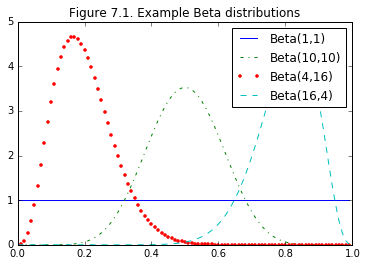

In [117]:
%matplotlib inline

import matplotlib.pyplot as plt

xs = [x / 100.0 for x in range(0, 100)]
plt.plot(xs,[beta_pdf(x, 1,1) for x in xs], "-", label="Beta(1,1)")
plt.plot(xs,[beta_pdf(x, 10,10) for x in xs], "-.", label="Beta(10,10)")
plt.plot(xs,[beta_pdf(x, 4, 16) for x in xs], ".", label="Beta(4,16)")
plt.plot(xs,[beta_pdf(x, 16,4) for x in xs], "--", label="Beta(16,4)")
plt.legend()
plt.title("Figure 7.1. Example Beta distributions")
plt.show()


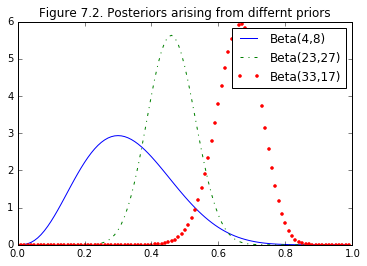

In [119]:
xs = [x / 100.0 for x in range(0, 100)]
plt.plot(xs,[beta_pdf(x, 4, 8) for x in xs], "-", label="Beta(4,8)")
plt.plot(xs,[beta_pdf(x, 23, 27) for x in xs], "-.", label="Beta(23,27)")
plt.plot(xs,[beta_pdf(x, 33, 17) for x in xs], ".", label="Beta(33,17)")
plt.legend()
plt.title("Figure 7.2. Posteriors arising from differnt priors")
plt.show()